In [ ]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("bigfoot").getOrCreate()

In [3]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.1/22-big-data/bigfoot.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("bigfoot.csv"), header=True, inferSchema=True, timestampFormat="yyyy/MM/dd HH:mm:ss")

# Show DataFrame
df.show()

+------+--------------------+--------------+--------------------+--------+---------+
|number|               title|classification|           timestamp|latitude|longitude|
+------+--------------------+--------------+--------------------+--------+---------+
|   637|Report 637: Campe...|       Class A|2000-06-16T12:00:00Z|    61.5|   -142.9|
|  2917|Report 2917: Fami...|       Class A|1995-05-15T12:00:00Z| 55.1872|-132.7982|
|  7963|Report 7963: Sasq...|       Class A|2004-02-09T12:00:00Z| 55.2035|-132.8202|
|  9317|Report 9317: Driv...|       Class A|2004-06-18T12:00:00Z| 62.9375|-141.5667|
| 13038|Report 13038: Sno...|       Class A|2004-02-15T12:00:00Z| 61.0595|-149.7853|
| 23666|Report 23666: Pas...|       Class A|2008-04-23T12:00:00Z|62.77335|-141.3165|
| 26604|Report 26604: Day...|       Class A|2009-07-15T12:00:00Z|64.89139|-147.8142|
|   179|Report 179: Man a...|       Class A|1981-09-15T12:00:00Z|32.31435|-85.16235|
|   245|Report 245: Two o...|       Class A|1999-07-15T12:00:00Z|

In [ ]:
# Import date time functions
from pyspark.sql.functions import month, year

In [5]:
# Create a new DataFrame with the column Year
df.select(year(df["timestamp"])).show()

+---------------+
|year(timestamp)|
+---------------+
|           2000|
|           1995|
|           2004|
|           2004|
|           2004|
|           2008|
|           2009|
|           1981|
|           1999|
|           1983|
|           2000|
|           1993|
|           1999|
|           1978|
|           1980|
|           1997|
|           1990|
|           1996|
|           2000|
|           2001|
+---------------+
only showing top 20 rows



In [6]:
# Save the year as a new column
df = df.withColumn("year", year(df['timestamp']))
df.show()

+------+--------------------+--------------+--------------------+--------+---------+----+
|number|               title|classification|           timestamp|latitude|longitude|year|
+------+--------------------+--------------+--------------------+--------+---------+----+
|   637|Report 637: Campe...|       Class A|2000-06-16T12:00:00Z|    61.5|   -142.9|2000|
|  2917|Report 2917: Fami...|       Class A|1995-05-15T12:00:00Z| 55.1872|-132.7982|1995|
|  7963|Report 7963: Sasq...|       Class A|2004-02-09T12:00:00Z| 55.2035|-132.8202|2004|
|  9317|Report 9317: Driv...|       Class A|2004-06-18T12:00:00Z| 62.9375|-141.5667|2004|
| 13038|Report 13038: Sno...|       Class A|2004-02-15T12:00:00Z| 61.0595|-149.7853|2004|
| 23666|Report 23666: Pas...|       Class A|2008-04-23T12:00:00Z|62.77335|-141.3165|2008|
| 26604|Report 26604: Day...|       Class A|2009-07-15T12:00:00Z|64.89139|-147.8142|2009|
|   179|Report 179: Man a...|       Class A|1981-09-15T12:00:00Z|32.31435|-85.16235|1981|
|   245|Re

In [7]:
# Find the total bigfoot sightings per year
averages = df.groupBy("year").count()
averages.orderBy("year").select("year", "count").show()

+----+-----+
|year|count|
+----+-----+
|null|    6|
|1869|    1|
|1921|    1|
|1925|    1|
|1930|    1|
|1932|    1|
|1934|    1|
|1937|    1|
|1938|    1|
|1941|    1|
|1942|    1|
|1944|    2|
|1947|    1|
|1948|    1|
|1949|    2|
|1950|    3|
|1952|    1|
|1953|    2|
|1954|    1|
|1955|    3|
+----+-----+
only showing top 20 rows



In [8]:
# Import the summarized data to a pandas DataFrame for plotting
# Note: If your summarized data is still too big for your local memory then your notebook may crash
import pandas as pd
pandas_df = averages.orderBy("year").select("year", "count").toPandas()
pandas_df.head()

,year,count
0,NaN,6
1,1869.0,1
2,1921.0,1
3,1925.0,1
4,1930.0,1


In [9]:
# Clean the data and rename the columns to "year" and "sightings"
pandas_df = pandas_df.dropna()
pandas_df = pandas_df.rename(columns={"count": "sightings"})
pandas_df.head()

,year,sightings
1,1869.0,1
2,1921.0,1
3,1925.0,1
4,1930.0,1
5,1932.0,1


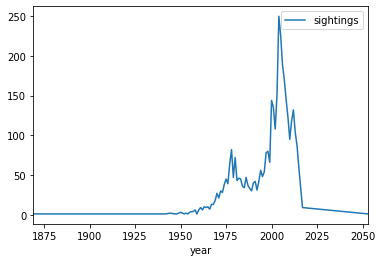

In [10]:
# Plot the year and sightings
%matplotlib inline
pandas_df.plot("year", "sightings")